# Stray light analysis (Part 1)

This Notebook investigates the brightness contrast given by the Sentinel 2 alebdo scene within a given ACT distance. 
The TANGO Carbon stray light kernel covers a typical area of about +- 25 pixels around the center of the stray light kernel. 
For simplicity reasons,  we coadd S2 data to 300m x 100m pixels that represent a typical pixel size 300 x80 m2. 


![kernel.png](kernel.png)

## 1. Set working enviroment

In [1]:
import sys
sys.path.append("/home/jochen/pythonenvs/tangoendtoend/lib64/python3.11/site-packages")
import os
import yaml
import numpy as np
from netCDF4 import Dataset
from copy import deepcopy
import matplotlib.pyplot as plt
from netCDF4 import Dataset

# define  path to search for module
sys.path.append("/home/jochen/TANGO_E2ES/EndtoEndProject/end_to_end/")
os.chdir("/home/jochen/TANGO_E2ES/EndtoEndProject/end_to_end/examples/exp7_straylight/")

## 2. Import teds modules

In [2]:
from teds.gm.gm import geometry_module
from teds.sgm import geoscene_generation
from teds.pam import pam_co2


## 3 Switch on/off cells

In [ ]:
proc_gm_= True
pam_gm  = True
proc_sgmgeo = True
pam_sgmgeo  = True
proc_sgmrad_scene   = True

## 4. Run GM and SGM for geophysical scenes to estimate ACT variability of the albedo

In [4]:
#Four reference scenes can be used: (1) Matimba, (2) Jenschwalde, (3) Belchatow, (4) Lipetsk.
station_name = 'Matimba'
#station_name = 'Jaenschwalde'
#station_name = 'Belchatow'
station_name = 'Lipetsk'

### 4.1 GM 

In [ ]:
if(proc_gm):
    #configureation file
    gm_config   = yaml.safe_load(open('./settings/gm_config.yaml'))
    gm_stations = yaml.safe_load(open('./settings/gm_station_parameter.yaml'))
    #select the list for the selected target
    gm_config['orbit'] = gm_stations[station_name]['orbit']
    gm_config['sensor'] = gm_stations[station_name]['sensor']

    geometry_module(gm_config)

[12:04:07] [WARNING] unrecognized input parameter: integration_time
[12:04:07] Generating detector image timestamps
[12:04:07] Generating orbit timestamps
[12:04:07] Generating satellite orbit


#########################
# Tango geometry module #
#########################
Version                 : 0.0.1
Commit hash             : 7d395538
Date and timezone       : 2025 February 11 Tue
Contacts                : raullaasner@gmail.com
                          bitbucket.org/sron_earth/teds/issues (request permission)
Host system             : Linux 6.8.0-52-generic



[12:04:14] Generating attitude quaternions
[12:04:15] Geolocation



###########
# Success #
###########


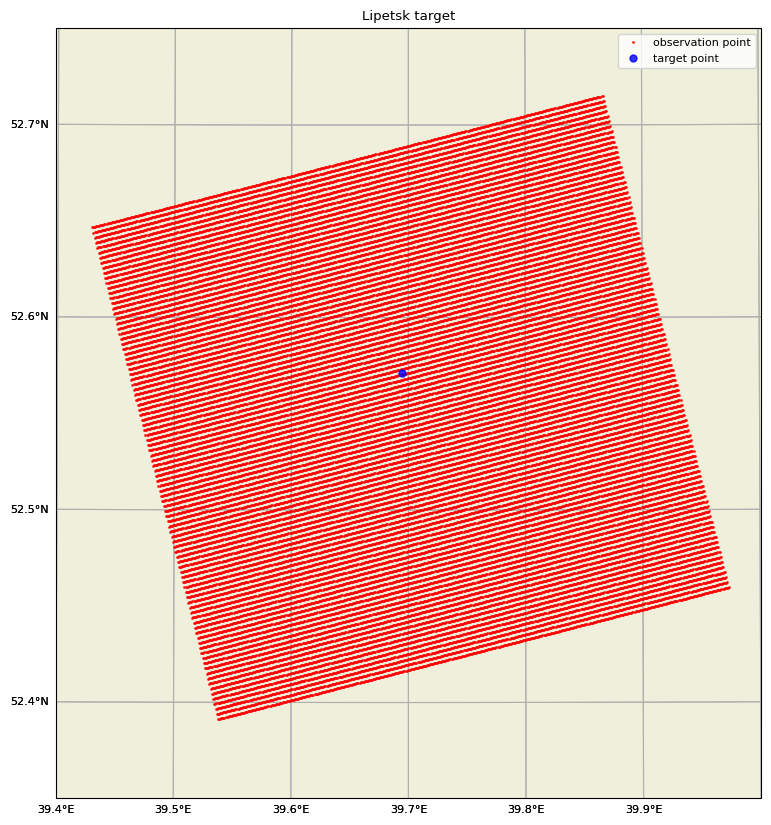

In [6]:
if(pam_gm):
    gm_config= yaml.safe_load(open('./settings/gm_config.yaml'))
    filen = gm_config['io_files']['geometry']
    plt_option = 'geoloc'
    pam_co2.pam_gm_Tango_Carbon(filen, station_name, plt_option)

### 4.2 SGM-GEO

The SGM-GEO procides a scene on a 100x100 m2 mesh. The albedo data are used to estimate brightness variation for stray light.  

In [ ]:
if(proc_sgmgeo):
    sgmgeo_stations= yaml.safe_load(open('./settings/geosgm_station_parameter.yaml'))
    sgmgeo_config= yaml.safe_load(open('./settings/geosgm_config.yaml'))
    #adjust target specific configs
    sgmgeo_config['io_files']['input_s2'] = sgmgeo_stations[station_name]['input_s2']
    sgmgeo_config['io_files']['meteo'] = sgmgeo_stations[station_name]['meteo']

    geoscene_generation(sgmgeo_config)

Getting meteo data ...
                     ...done
Combining microHH and AFGL model


100%|██████████| 368/368 [00:03<00:00, 117.46it/s]



###########
# Success #
###########


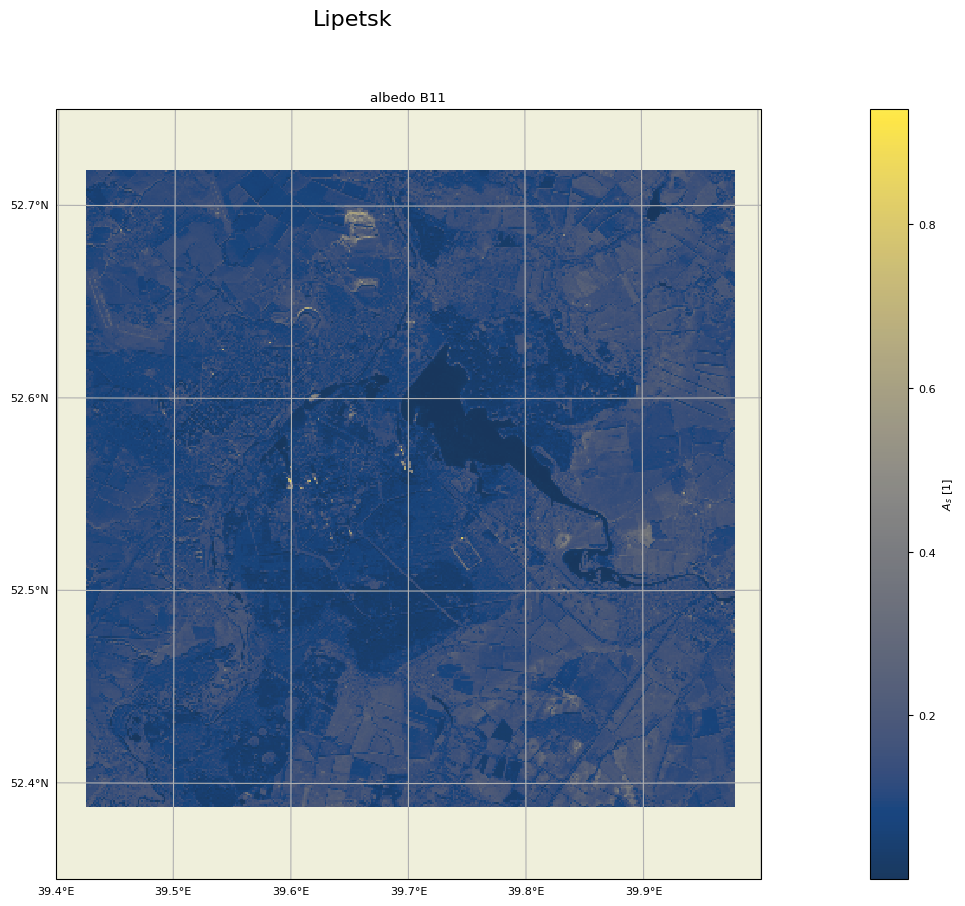

In [ ]:
if(pam_sgmgeo):
    sgmgeo_config= yaml.safe_load(open('./settings/geosgm_config.yaml'))
    filen = sgmgeo_config['io_files']['output_geo']
    plt_option = 'albedo B11'
    pam_co2.pam_sgm_gps(filen, station_name, plt_option)

SGM-GEO data are given on a (alt,act) 100x100 m2 grid. We change this to a 300x100 m2 grid. This is a good estimate of the size of a ground scene resolved  by the detector.

Text(0.5, 1.0, 'P(99) =0.285 ')

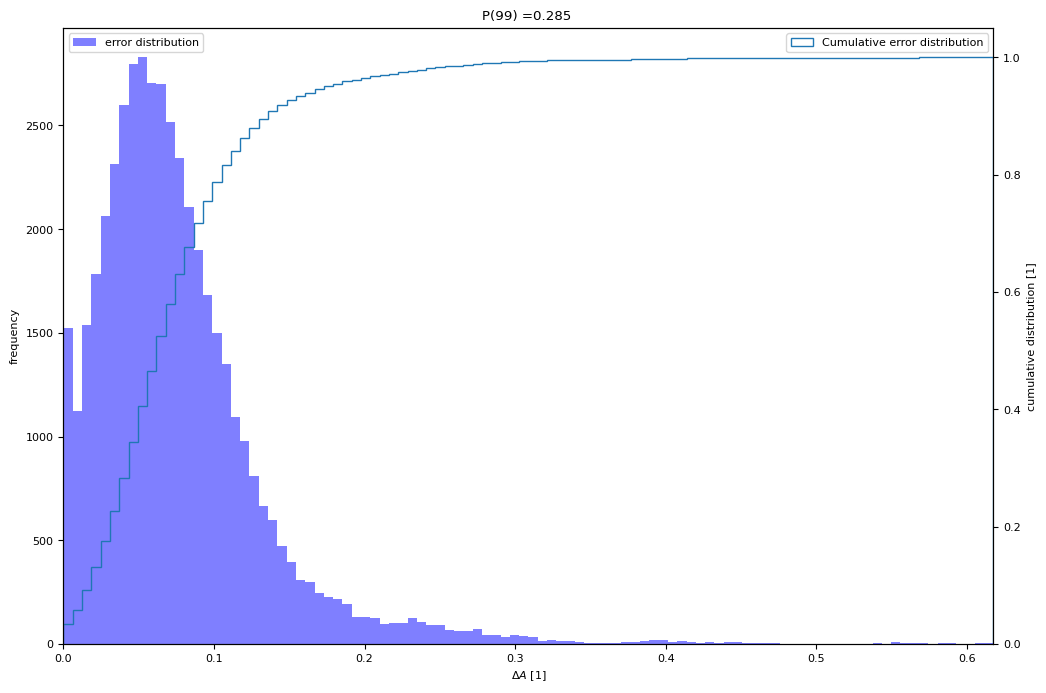

In [ ]:
sgmgeo_data = Dataset('/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/sgm/Tango_Carbon_sgm_atmosphere_exp7.0.nc')
albedo = sgmgeo_data['albedo B11']

nalt, nact = albedo.shape
nbin = 3 
nalt_binned = np.int16(nalt/nbin)
albedo_binned = np.zeros([nalt_binned, nact])
for ialtb in range(nalt_binned):
    albedo_binned[ialtb,:]= np.mean(albedo[nbin*ialtb:nbin*(ialtb+1),:],axis=0)

#for each ALT position calculate the maximum albedo variation within +- npixel ACT
#We choose for npixel = 25 based on the stray light kernel simulations provided by TNO (see figure above).

npixel = 25
alb_var = np.zeros([nalt_binned, nact])
for ialt in range(nalt_binned):
  for iact in range(nact):
    iact_min = np.max([0, iact-npixel])
    iact_max = np.min([nact, iact+npixel])
    alb_var[ialt,iact] = np.max(albedo_binned[ialt, iact_min:iact_max]-albedo_binned[ialt,iact])

data = alb_var.flatten()

#plotting data distribution,and 99% percentile.
data_max = np.max(data)

num_bins = 101
bindef = np.arange(num_bins)
bindef = data_max*bindef/np.max(bindef)

fig, ax1  = plt.subplots(
    1,
    1,
    figsize=(12, 8),
    dpi=100,)

ax1.hist(data,
  bins  = bindef,
  alpha = 0.5,
  color = 'blue',
  label = 'error distribution')
ax1.set_xlabel('$\Delta A$ [1]')
ax1.set_ylabel('frequency')
ax1.set_xlim(0,data_max)
ax1.legend(loc = 'upper left')

ax2 = ax1.twinx()
ax2.set_ylabel("cumulative distribution [1]")
ax2.hist(data, 
  bins= bindef, 
  density = True, 
  histtype = "step",
  cumulative = True, 
  label = "Cumulative error distribution")
ax2.legend(loc = 'upper right')
P99 = np.percentile(data,99.)
plt.title(f"P(99) ={P99:.3f} ")

## Results
+ Jaenschwalde P99 = 0.39

+ Lipetsk      P99 = 0.29

+ Balchatow    P99 = 0.29

+ Matimba      P99 = 0.24

Based on this analysis, we use a contract scene of $\Delta A = 0.3$.